Saving Disease_symptom_and_patient_profile_dataset.csv to Disease_symptom_and_patient_profile_dataset.csv
Dataset shape: (349, 10)

First 5 rows:
       Disease Fever Cough Fatigue Difficulty Breathing  Age  Gender  \
0    Influenza   Yes    No     Yes                  Yes   19  Female   
1  Common Cold    No   Yes     Yes                   No   25  Female   
2       Eczema    No   Yes     Yes                   No   25  Female   
3       Asthma   Yes   Yes      No                  Yes   25    Male   
4       Asthma   Yes   Yes      No                  Yes   25    Male   

  Blood Pressure Cholesterol Level Outcome Variable  
0            Low            Normal         Positive  
1         Normal            Normal         Negative  
2         Normal            Normal         Negative  
3         Normal            Normal         Positive  
4         Normal            Normal         Positive  

Column names: ['Disease', 'Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 'Age', 'Gender', 

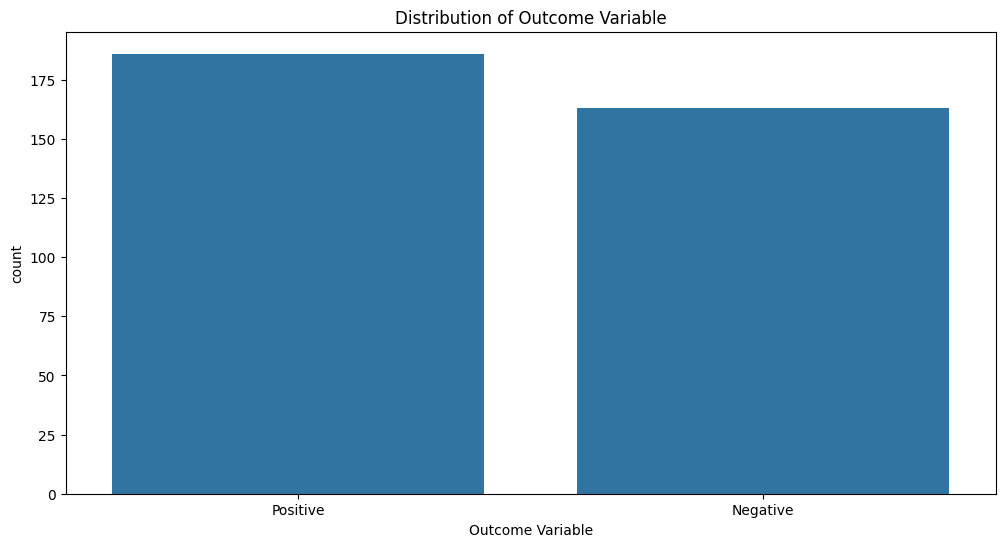

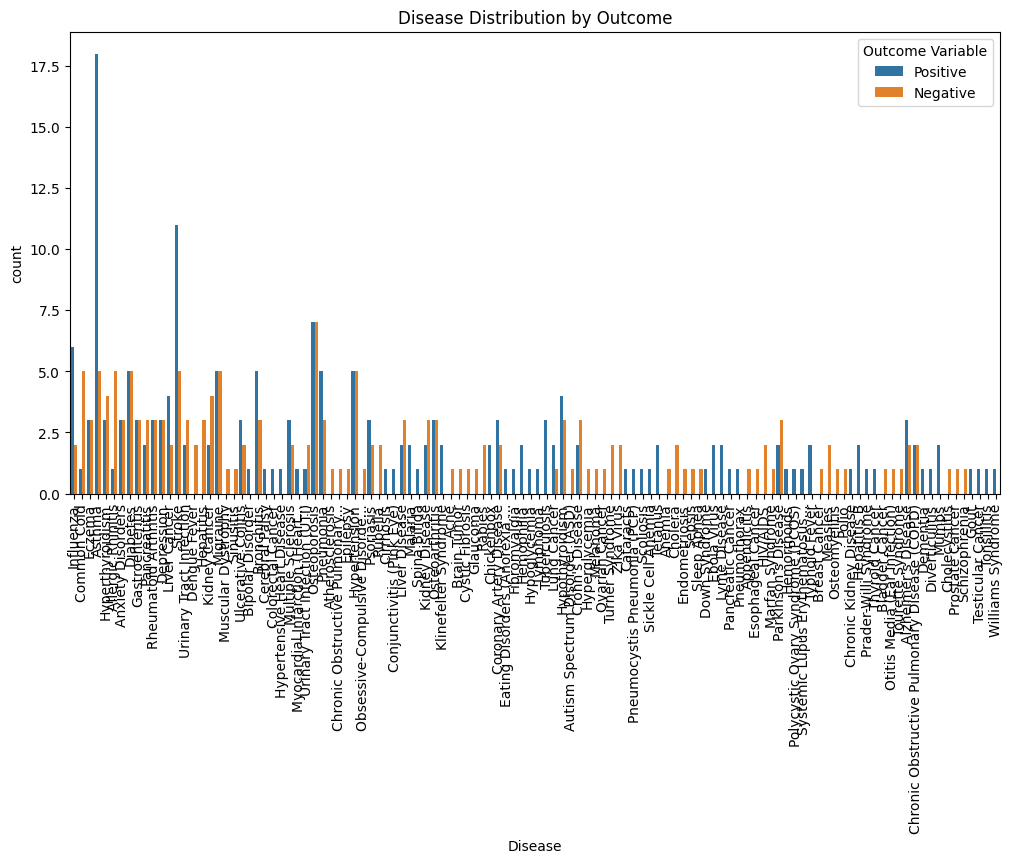

Model trained with accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.72      0.78        36
    Positive       0.77      0.87      0.82        39

    accuracy                           0.80        75
   macro avg       0.81      0.80      0.80        75
weighted avg       0.80      0.80      0.80        75



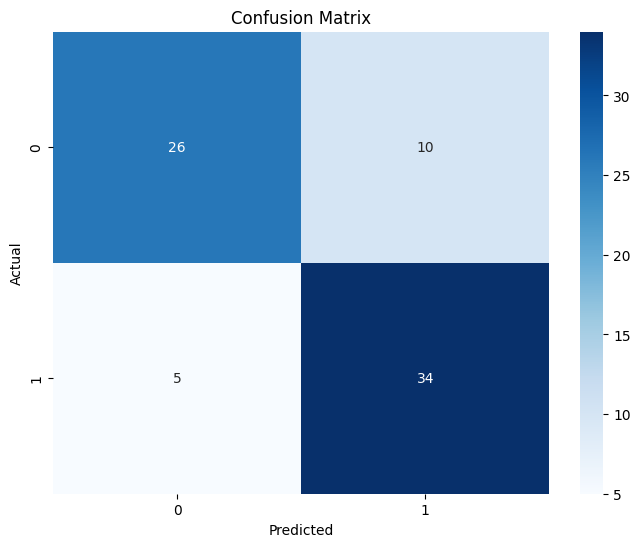

Model saved to healthcare_predictor.pkl


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Launching local interface...
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://db422149b026bc22d1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



To get a public URL, please set up ngrok with your auth token.
Error: Error: credential propagation was unsuccessful


In [3]:
!pip install gradio pyngrok # Install both gradio and pyngrok
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import joblib
import gradio as gr
from pyngrok import ngrok

# ... (rest of the code remains the same) ...
# Load the dataset
from google.colab import files
uploaded = files.upload()

# Read the dataset
df = pd.read_csv('Disease_symptom_and_patient_profile_dataset.csv')

# Data Exploration
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nColumn names:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())

# Visualize the data
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Outcome Variable')
plt.title('Distribution of Outcome Variable')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Disease', hue='Outcome Variable')
plt.title('Disease Distribution by Outcome')
plt.xticks(rotation=90)
plt.show()

# Data Preprocessing
class HealthcarePredictor:
    def __init__(self):
        self.model = None
        self.scaler = None
        self.label_encoders = {}
        self.feature_names = None

    def preprocess_data(self, df, target_column='Outcome Variable'):
        """Clean and preprocess patient data"""
        # Convert binary columns to numeric
        binary_cols = ['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing']
        for col in binary_cols:
            df[col] = df[col].map({'Yes': 1, 'No': 0})

        # Encode categorical variables
        categorical_cols = df.select_dtypes(include=['object']).columns
        categorical_cols = [col for col in categorical_cols if col not in binary_cols + [target_column, 'Disease']]

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            self.label_encoders[col] = le

        # Separate features and target
        X = df.drop([target_column, 'Disease'], axis=1)
        y = df[target_column]

        # Store feature names for later use
        self.feature_names = X.columns.tolist()

        # Handle class imbalance
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X, y)

        # Scale numerical features
        self.scaler = StandardScaler()
        numerical_cols = ['Age', 'Cholesterol Level']
        X_res[numerical_cols] = self.scaler.fit_transform(X_res[numerical_cols])

        return X_res, y_res

    def train_model(self, X, y):
        """Train a Random Forest classifier"""
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        self.model = RandomForestClassifier(
            n_estimators=200,
            max_depth=12,
            random_state=42,
            class_weight='balanced'
        )

        self.model.fit(X_train, y_train)

        # Evaluate model
        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Model trained with accuracy: {accuracy:.2f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        return self.model

    def predict_disease_risk(self, input_data):
        """Predict disease risk for new patient data"""
        if not self.model:
            print("Model not trained yet")
            return None

        # Convert input to DataFrame
        input_df = pd.DataFrame([input_data])

        # Convert binary columns
        binary_cols = ['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing']
        for col in binary_cols:
            input_df[col] = input_df[col].map({'Yes': 1, 'No': 0})

        # Encode categorical variables
        for col, le in self.label_encoders.items():
            if col in input_df.columns:
                input_df[col] = le.transform(input_df[col])

        # Ensure all expected columns are present
        for col in self.feature_names:
            if col not in input_df.columns:
                input_df[col] = 0

        # Reorder columns to match training data
        input_df = input_df[self.feature_names]

        # Scale numerical features
        numerical_cols = ['Age', 'Cholesterol Level']
        input_df[numerical_cols] = self.scaler.transform(input_df[numerical_cols])

        # Make prediction
        prediction = self.model.predict(input_df)
        probabilities = self.model.predict_proba(input_df)

        return prediction[0], probabilities[0]

    def save_model(self, filepath):
        """Save trained model to file"""
        joblib.dump({
            'model': self.model,
            'scaler': self.scaler,
            'label_encoders': self.label_encoders,
            'feature_names': self.feature_names
        }, filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        """Load trained model from file"""
        saved_data = joblib.load(filepath)
        self.model = saved_data['model']
        self.scaler = saved_data['scaler']
        self.label_encoders = saved_data['label_encoders']
        self.feature_names = saved_data['feature_names']
        print(f"Model loaded from {filepath}")

# Initialize and train the predictor
predictor = HealthcarePredictor()
X, y = predictor.preprocess_data(df)
predictor.train_model(X, y)

# Save the trained model
predictor.save_model('healthcare_predictor.pkl')

# Create Gradio interface
def predict_health(fever, cough, fatigue, difficulty_breathing, age, gender,
                   blood_pressure, cholesterol_level):
    input_data = {
        'Fever': fever,
        'Cough': cough,
        'Fatigue': fatigue,
        'Difficulty Breathing': difficulty_breathing,
        'Age': age,
        'Gender': gender,
        'Blood Pressure': blood_pressure,
        'Cholesterol Level': cholesterol_level
    }

    prediction, probabilities = predictor.predict_disease_risk(input_data)

    result = f"Prediction: {'Positive' if prediction == 'Positive' else 'Negative'}\n\n"
    result += "Probability Scores:\n"
    result += f"Positive: {probabilities[1]*100:.1f}%\n"
    result += f"Negative: {probabilities[0]*100:.1f}%"

    # Interpretation
    if prediction == 'Positive':
        result += "\n\nRecommendation: Consult with a healthcare professional for further evaluation."
    else:
        result += "\n\nRecommendation: Continue with regular health checkups."

    return result

# Define input components
inputs = [
    gr.Dropdown(["Yes", "No"], label="Fever"),
    gr.Dropdown(["Yes", "No"], label="Cough"),
    gr.Dropdown(["Yes", "No"], label="Fatigue"),
    gr.Dropdown(["Yes", "No"], label="Difficulty Breathing"),
    gr.Number(label="Age", minimum=0, maximum=120),
    gr.Dropdown(["Male", "Female"], label="Gender"),
    gr.Dropdown(["Low", "Normal", "High"], label="Blood Pressure"),
    gr.Number(label="Cholesterol Level", minimum=100, maximum=400)
]

outputs = gr.Textbox(label="Health Risk Prediction")

# Create interface
interface = gr.Interface(
    fn=predict_health,
    inputs=inputs,
    outputs=outputs,
    title="🩺 AI-Powered Health Risk Assessment",
    description="Enter patient symptoms and health metrics to assess disease risk",
    allow_flagging="never"
)

# Launch the app (local URL)
print("Launching local interface...")
interface.launch()

# For public URL (requires ngrok auth token)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    !mkdir -p /content/drive/MyDrive/ngrok
    !cp /content/drive/MyDrive/ngrok/ngrok.yml /root/.ngrok2/

    # Get ngrok public URL
    public_url = ngrok.connect(addr='7860')
    print("\nPublic URL:", public_url)
except Exception as e:
    print("\nTo get a public URL, please set up ngrok with your auth token.")
    print("Error:", e)